<a href="https://colab.research.google.com/github/pedrostrepeckes/Finance/blob/main/Estudo_BPAC11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Estudo BPAC11

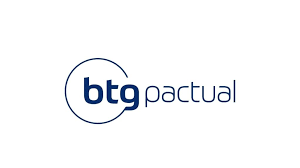

##Preparação do Notebook

In [112]:
!pip install sweetviz --quiet
!pip install vectorbt --quiet
!pip install nasdaq-data-link --quiet
import vectorbt as vbt
!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nasdaqdatalink
import os
import seaborn as sns

##Definições

In [189]:
ticker = 'B3SA3.SA'
ticker_bovespa = '^BVSP'
start_date = '2018-01-01'
interval_set = '1d'
chave = 'XT2Zic-Ppuh4dxSz6hrA'
nasdaqdatalink.ApiConfig.api_key = chave

In [190]:
ibov = yf.download(ticker_bovespa, start = start_date, interval = interval_set)['Close']
acao = yf.download(ticker, start = start_date, interval = interval_set )['Adj Close']
selic = nasdaqdatalink.get('BCB/432', start_date= start_date, collapse = 'daily')
ipca_acum_12m = nasdaqdatalink.get('BCB/13522',start_date=start_date, collapse = 'daily')
igpm = nasdaqdatalink.get('BCB/189', start_date=start_date, collapse = 'daily')
dolar = nasdaqdatalink.get('BCB/10813', start_date=start_date, collapse = 'daily')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [191]:
fig = go.Figure()
fig.add_trace(go.Scatter(name='IPCA', x=ipca_acum_12m.index, y=ipca_acum_12m.Value ))
fig.update_layout(title_text='<b>IPCA Acumulado 12M', template='plotly_dark')
fig.show()

In [192]:
selic2 = pd.DataFrame()
ipca2 = pd.DataFrame()
igpm2 = pd.DataFrame()
dolar2 = pd.DataFrame()
selic2['SELIC'] = selic.copy()
ipca2['IPCA'] = ipca_acum_12m.copy()
igpm2['IGPM'] = igpm.copy()
dolar2['DOLAR'] = dolar.copy()
macros = pd.concat([selic2, ipca2, igpm2, dolar2], axis=1)
macros

,SELIC,IPCA,IGPM,DOLAR
Date,,,,
2018-01-01,7.00,NaN,NaN,NaN
2018-01-02,7.00,NaN,NaN,3.2691
2018-01-03,7.00,NaN,NaN,3.2529
2018-01-04,7.00,NaN,NaN,3.2312
2018-01-05,7.00,NaN,NaN,3.2403
...,...,...,...,...
2023-06-20,13.75,NaN,NaN,4.7924
2023-06-21,13.75,NaN,NaN,4.7789
2023-06-22,13.75,NaN,NaN,4.7744


In [193]:
macros.fillna(method = 'ffill', inplace = True)
#macros.fillna(method = 'bfill', inplace = True) #muito cuidado com a visão do futuro

In [194]:
acao_ibov = pd.merge(acao, ibov, how='inner', left_index = True, right_index=True)
comparativo_acao_macros = pd.merge(acao_ibov, macros, how='inner', left_index = True, right_index=True)
comparativo_acao_macros.rename(columns={'Adj Close':ticker,'Close':'IBOV'}, inplace = True)
comparativo_acao_macros

,B3SA3.SA,IBOV,SELIC,IPCA,IGPM,DOLAR
Date,,,,,,
2018-01-02,6.272576,77891.0,7.00,NaN,NaN,3.2691
2018-01-03,6.379354,77995.0,7.00,NaN,NaN,3.2529
2018-01-04,6.420423,78647.0,7.00,NaN,NaN,3.2312
2018-01-05,6.513511,79071.0,7.00,NaN,NaN,3.2403
2018-01-08,6.543629,79379.0,7.00,NaN,NaN,3.2351
...,...,...,...,...,...,...
2023-06-19,14.800000,119858.0,13.75,3.94,-1.84,4.7797
2023-06-20,14.730000,119622.0,13.75,3.94,-1.84,4.7924
2023-06-21,14.640000,120420.0,13.75,3.94,-1.84,4.7789


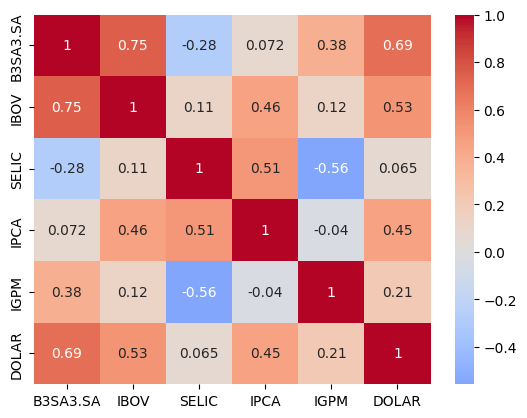

In [195]:
nome_colunas = comparativo_acao_macros.columns
sns.heatmap(comparativo_acao_macros.corr(), cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2g',
            xticklabels=nome_colunas,
            yticklabels=nome_colunas);

In [196]:
fig = make_subplots(rows=1, cols=1, specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(name=ticker, x=comparativo_acao_macros.index, y=comparativo_acao_macros[ticker]),row=1, col=1)
fig.add_trace(go.Scatter(name='DOLAR', x=comparativo_acao_macros.index, y=comparativo_acao_macros['DOLAR']),row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name='IPCA', x=comparativo_acao_macros.index, y=comparativo_acao_macros['IPCA']),row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name='SELIC', x=comparativo_acao_macros.index, y=comparativo_acao_macros['SELIC']),row=1, col=1, secondary_y=True)
fig.update_layout(title_text=ticker+' VS Macros', template='simple_white')
fig.show()

In [197]:
comparativo_normalizado = (comparativo_acao_macros/comparativo_acao_macros.iloc[0])

In [198]:
#usando todas as colunas automaticamente
fig = make_subplots(rows=1, cols=1, specs=[[{'secondary_y': True}]])
for index in comparativo_normalizado.columns:
  fig.add_trace(go.Scatter(name=index, x=comparativo_normalizado.index, y=comparativo_normalizado[index]),row=1, col=1)
fig.update_layout(title_text=ticker+' VS Macros Normalizados', template='simple_white')
fig.show()

In [199]:
acao_info = yf.Ticker(ticker)

In [200]:
acao_info.info['previousClose']

14.2

In [204]:
acao_info.info['bid']

14.35